In [10]:

import pandas as pd
import geopandas as gpd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns 
import datetime as dt 
from pandas import Timestamp
import re
import urllib
import nltk
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [11]:
df = pd.read_csv(r'ctg-studies.csv', sep=',', parse_dates=True)

In [12]:
df

,NCT Number,Study Title,Study Status,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Sponsor,Collaborators,Funder Type,Study Type,Start Date,Completion Date,Locations
0,NCT03695705,Rifaximin and Norfloxacin for Prevention of SB...,COMPLETED,"Cirrhosis, Liver",DRUG: Rifaximin 550 mg twice a day and Norflox...,Incidence SBP in patients on Rifaximin prophyl...,"Incidence of hepatic encephalopathy, Incidence...",Postgraduate Institute of Medical Education an...,NaN,OTHER_GOV,INTERVENTIONAL,2016-01-01,2017-06-30,NaN
1,NCT01893905,Efficacy and Safety of a New Formulation of Ch...,COMPLETED,Knee Osteoarthritis,DRUG: CS+SG|DRUG: Placebo,"Change in Pain According to VAS (0-100 mm), VA...",NaN,"Tedec-Meiji Farma, S.A.",NaN,INDUSTRY,INTERVENTIONAL,2013-06,2014-08,"Complejo Hospitalario Universitario La Coruña,..."
2,NCT00478049,Iressa as Second Line Therapy in Advanced NSCL...,COMPLETED,NSCLC,DRUG: Gefitinib|DRUG: Docetaxel,Compare progression free survival between pati...,To compare the overall objective tumor respons...,AstraZeneca,NaN,INDUSTRY,INTERVENTIONAL,2005-09,2009-02,"Research Site, In Cheon, Korea, Republic of|Re..."
3,NCT00047749,Prialt (Ziconotide) In Severe Chronic Pain,COMPLETED,Pain,DRUG: Prialt (ziconotide),NaN,NaN,Elan Pharmaceuticals,NaN,INDUSTRY,INTERVENTIONAL,2002-08,2003-06,Tennesee Valley Pain Consultants - Center For ...
4,NCT04576949,A Study of Cytisinicline for Smoking Cessation...,COMPLETED,Smoking Cessation,DRUG: Cytisinicline|DRUG: Placebo|BEHAVIORAL: ...,Proportion of participants with smoking abstin...,Proportion of participants with continuous smo...,Achieve Life Sciences,NaN,INDUSTRY,INTERVENTIONAL,2020-10-13,2021-12-23,"Alliance for Multispecialty Research, LLC., Mo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31459,NCT00099996,Higher-Dose Ezetimibe to Treat Homozygous Sito...,COMPLETED,"Heart Diseases|Metabolism, Inborn Errors",DRUG: SCH-58235|DRUG: Ezetimibe,NaN,NaN,"National Heart, Lung, and Blood Institute (NHLBI)",NaN,NIH,INTERVENTIONAL,2004-12,2005-12,"National Heart, Lung and Blood Institute (NHLB..."
31460,NCT00296595,Effects of n-3 Polyunsaturated Fatty Acids and...,COMPLETED,Cardiovascular Diseases|Vasodilation,BEHAVIORAL: Nutrition,"Changes in postprandial lipemia, oxidative str...",Changes in arterial flow-mediated vasodilatory...,Laval University,Canadian Institutes of Health Research (CIHR),OTHER,INTERVENTIONAL,2006-02,2008-12,Institute of Nutraceuticals and Functional Foo...
31461,NCT02744495,Prophylaxis of Postoperative Nausea and Vomiti...,COMPLETED,Postoperative Vomiting|Postoperative Nausea|Po...,DRUG: Betamethasone|DRUG: Droperidol,"postoperative nausea and vomiting, postoperati...","number of postoperative nausea and vomiting, 4...",Hôpital Privé de Parly II - Le Chesnay,NaN,OTHER,INTERVENTIONAL,2016-02,2016-12,"Parly2, Le Chesnay, 78150, France"
31462,NCT00031395,Clonidine in Attention Deficit Hyperactivity D...,COMPLETED,Attention Deficit Disorder With Hyperactivity,DRUG: clonidine|DRUG: methylphenidate|OTHER: p...,Efficacy outcome was change in score on the Co...,the ASQ-Parent (ASQ-P) and Child Global Assess...,University of Cincinnati,National Institute of Neurological Disorders a...,OTHER,INTERVENTIONAL,1999-09,2007-06,"SUNY Buffalo, Center For Children & Families, ..."


In [13]:
def data_treatment(df, filter=True):
    """Fonction pour traiter les dataframe

    Args:
        df (Dataframe): Dataframe de données clinical trials
        filter (bool, optional): Supprimer ou non les valeurs non pertinentes. Defaults to True.

    Returns:
        Dataframe: dataframe traité
    """
    df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce')
    df['Completion Date'] = pd.to_datetime(df['Completion Date'], errors='coerce')
    # Créer une nouvelle colonne avec la différence en jours
    df['TimePassed'] = (df['Completion Date'] - df['Start Date']).dt.days
    df['TimePassed'] = df['TimePassed'].fillna(0)
    df['Bin']=df['TimePassed'].apply(lambda x: 1 if x>5 else 0)
    if filter:
        df = df[df['Bin']==1].reset_index(drop=True) #On supprime les valeurs trop petites/protocoles non terminés (ou n'ayant pas de date de fin prévue)
        df = df[df['TimePassed']<1000].reset_index(drop=True) #On supprime aussi les valeurs trop élevés considérés comme des outliers (Seuil objectif)
       
    return df


# Data preprocessing

## 1. Study status

In [14]:
df = data_treatment(df, filter = True)

In [15]:
df

,NCT Number,Study Title,Study Status,Conditions,Interventions,Primary Outcome Measures,Secondary Outcome Measures,Sponsor,Collaborators,Funder Type,Study Type,Start Date,Completion Date,Locations,TimePassed,Bin
0,NCT03695705,Rifaximin and Norfloxacin for Prevention of SB...,COMPLETED,"Cirrhosis, Liver",DRUG: Rifaximin 550 mg twice a day and Norflox...,Incidence SBP in patients on Rifaximin prophyl...,"Incidence of hepatic encephalopathy, Incidence...",Postgraduate Institute of Medical Education an...,NaN,OTHER_GOV,INTERVENTIONAL,2016-01-01,2017-06-30,NaN,546.0,1
1,NCT04576949,A Study of Cytisinicline for Smoking Cessation...,COMPLETED,Smoking Cessation,DRUG: Cytisinicline|DRUG: Placebo|BEHAVIORAL: ...,Proportion of participants with smoking abstin...,Proportion of participants with continuous smo...,Achieve Life Sciences,NaN,INDUSTRY,INTERVENTIONAL,2020-10-13,2021-12-23,"Alliance for Multispecialty Research, LLC., Mo...",436.0,1
2,NCT05516849,Placebo Versus Oxandrolone Supplementation in ...,WITHDRAWN,Trauma Injury,DRUG: Oxandrolone|OTHER: Placebo,Delta volumetric vastus medialis diameter on M...,"Delta volumetric thigh muscle mass on MRI, Del...",Sunnybrook Health Sciences Centre,United States Department of Defense|Walter Ree...,OTHER,INTERVENTIONAL,2022-05-19,2023-08-03,NaN,441.0,1
3,NCT03562949,A BE Study to Compare Beclomethasone Dipropion...,TERMINATED,Asthma,DRUG: Test Product|DRUG: Reference Product|DRU...,"Baseline-adjusted, pre-dose FEV1 on the last d...",NaN,Amneal Ireland Limited,NaN,INDUSTRY,INTERVENTIONAL,2018-12-06,2019-08-02,"Beach Clinical Research, Inc., Huntington Beac...",239.0,1
4,NCT05020249,A Study to Evaluate the Efficacy and Safety of...,COMPLETED,Moderate to Severe Plaque Psoriasis,DRUG: bimekizumab|OTHER: Placebo,Psoriasis Area and Severity Index (PASI) 90 re...,Psoriasis Area and Severity Index (PASI) 100 r...,UCB Biopharma SRL,NaN,INDUSTRY,INTERVENTIONAL,2021-09-27,2022-09-06,"Ps0032 20211, Bucheon-si, Korea, Republic of|P...",344.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6055,NCT03921996,Extended Pelvic Lymph Node Dissection vs. no P...,TERMINATED,Prostate Cancer,PROCEDURE: Radical prostatectomy (RP) followed...,"Time to biochemical recurrence (BCR), The prim...","Prostate-specific antigen (PSA) persistence, P...",Swiss Group for Clinical Cancer Research,NaN,OTHER,INTERVENTIONAL,2019-08-27,2021-11-11,"Kantonsspital Aarau AG, Aarau, 5001, Switzerla...",807.0,1
6056,NCT03433196,Efficacy and Safety Study of the HS-25 Combina...,COMPLETED,Hypercholesterolemia in Coronaory Heart Disease,DRUG: HS-25 and Atorvastatin|DRUG: Atorvastatin,"Percent change of LDL-C, Percent change from b...","Percent change of Non-HDL-C, Percent change fr...",Zhejiang Hisun Pharmaceutical Co. Ltd.,NaN,INDUSTRY,INTERVENTIONAL,2016-06-07,2018-10-10,NaN,855.0,1
6057,NCT04951869,: Protescal: Prevention of Hypertrophic Scar a...,COMPLETED,Caesarean Wound|Hypertrophic Surgical Scar|Kel...,DRUG: Protescal gel,Name of the Measurement:Assessment of degree o...,Name of the Measurement: Assessment of pelvic ...,Universiti Kebangsaan Malaysia Medical Centre,NaN,OTHER,INTERVENTIONAL,2017-04-26,2017-11-16,"Universiti Kebangsaan Malaysia Medical Centre,...",204.0,1
6058,NCT00512135,Safety and Efficacy of NT 201 (Incobotulinumto...,COMPLETED,Glabellar Lines,DRUG: IncobotulinumtoxinA (Xeomin) (20 units),"Incidence of Adverse Events (AEs), Baseline up...",NaN,Merz Pharmaceuticals GmbH,NaN,INDUSTRY,INTERVENTIONAL,2007-06-18,2009-12-28,"Skin Care Centre, Los Angeles, California, 900...",924.0,1


In [16]:
df['Study Status'].value_counts()

Study Status
COMPLETED     5057
TERMINATED     816
WITHDRAWN      187
Name: count, dtype: int64

On s'intéresse au succès ou échec d'un essai clinique en phase III, donc on ne va pas fitter notre modèle sur les études en cours (= recruiting, active not recruting, not yet recruiting, enrolling by invitation), mais sur les études qui ont dépassé la phase III (completed=succès ou terminated, withdrawn = échec)

In [17]:
df = df[~df['Study Status'].isin(['UNKNOWN', 'SUSPENDED'])]

In [18]:
etude = df[df['Study Status'].isin(['TERMINATED', 'COMPLETED', 'WITHDRAWN'])]

In [19]:
etude['succes'] = etude['Study Status'].map(lambda x: int(x not in ['TERMINATED', 'WITHDRAWN']))

In [20]:
etude['Study Status'].value_counts()/etude.shape[0]*100 #pourcentage

Study Status
COMPLETED     83.448845
TERMINATED    13.465347
WITHDRAWN      3.085809
Name: count, dtype: float64

In [21]:
etude['succes'].value_counts()/etude.shape[0]*100 #pourcentage

succes
1    83.448845
0    16.551155
Name: count, dtype: float64

C:\Users\zargo\AppData\Local\Temp\ipykernel_20688\4005679766.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=etude['succes'], palette=palette)


Text(0.5, 0, 'Abandon/échec=0   |   Succès=1')

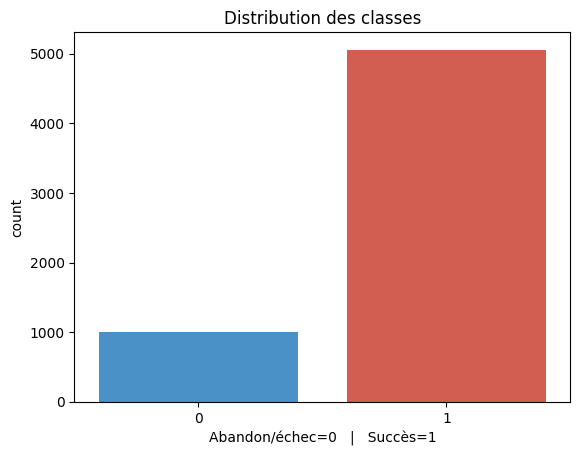

In [22]:
labels ='Abandon/échec=0   |   ' + 'Succès=1'
palette = ["#3494db", "#e74c3c"]
sns.countplot(x=etude['succes'], palette=palette)
plt.title('Distribution des classes')
plt.xlabel(labels)

## 2. Conditions

In [23]:
#etude.Conditions = etude.Conditions.map(lambda x: "".join(ch for ch in list(x) if ch.isalnum()))
#etude.Conditions = etude.Conditions.map(lambda x: ' '.join(re.findall('[A-Z][a-z]*', x)))

In [24]:
#etude.Conditions

In [25]:
etude.Conditions.values

array(['Cirrhosis, Liver', 'Smoking Cessation', 'Trauma Injury', ...,
       'Caesarean Wound|Hypertrophic Surgical Scar|Keloid Scar Following Surgery',
       'Glabellar Lines', 'Paroxysmal Supraventricular Tachycardia'],
      dtype=object)

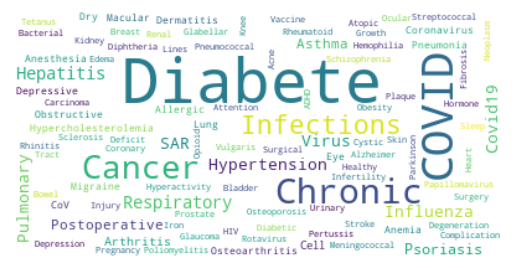

In [26]:
text = ' '.join(etude.Conditions.values)

stopwords = set(STOPWORDS)
stopwords.update(["B", "C", 'Disorders', "multiple", "moderate", "age", "induced", 'human', 'Primary', 'Failure', "Related", "mellitus", "deficiency", "stage", "dysfunction", "use", "major", "minor", "pre", "post", "infection", "diseases", "disorder", "pain", "non", "small", "type", "associated", "disease", "syndrome", "due", "acute", "severe", "high", "low"])
wordcloud = WordCloud(normalize_plurals = True, stopwords=stopwords, max_font_size=50, max_words=100, collocations = False, background_color="white", relative_scaling=1).generate(text)
#on enleve "mellitus" car c'est le nom scientifique du diabète : diabetes mellitus

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
wordcloud.words_.keys()

dict_keys(['Diabete', 'COVID', 'Chronic', 'Cancer', 'Infections', 'Respiratory', 'Hepatitis', 'Pulmonary', 'Covid19', 'Virus', 'Hypertension', 'Influenza', 'SAR', 'Psoriasis', 'Asthma', 'Postoperative', 'Arthritis', 'Cell', 'Osteoarthritis', 'CoV', 'Obstructive', 'Migraine', 'Eye', 'Pneumonia', 'Depressive', 'Hypercholesterolemia', 'Coronavirus', 'Allergic', 'Macular', 'Anesthesia', 'Lung', 'Dermatitis', 'Anemia', 'Dry', 'Kidney', 'Atopic', 'Breast', 'Plaque', 'Vaccine', 'Urinary', 'Heart', 'Rhinitis', 'Tract', 'Rheumatoid', 'Carcinoma', 'Bladder', 'Knee', 'Schizophrenia', 'Meningococcal', 'Lines', 'Vulgaris', 'HIV', 'Surgery', 'Acne', 'Fibrosis', 'Pneumococcal', 'Sclerosis', 'Prostate', 'Degeneration', 'Obesity', 'Opioid', 'Tetanus', 'Diabetic', 'Neoplasm', 'Glaucoma', 'Stroke', 'Renal', 'Diphtheria', 'Bacterial', 'Attention', 'Healthy', 'Ocular', 'Pertussis', 'Deficit', 'Parkinson', 'Injury', 'Osteoporosis', 'Growth', 'Skin', 'Depression', 'Hyperactivity', 'Infertility', 'Cystic', 'G

Les études cliniques qui ont complété la phase III (soldée par un succès ou un échec) portent principalement sur le cancer, le diabète, les maladies chroniques, l'hypertension, le SIDA, les maladies respiratoires, et les maladies mentales comme la schizophrénie ou la dépression. Explorons les caractéristiques de ces études en fonction d'autres variables. 

In [28]:
freq = list()
prob_success = list()
for condition in wordcloud.words_.keys():
    freq.append(etude[etude['Conditions'].str.contains(condition, case=False)].shape[0])
    prob_success.append(etude[etude['Conditions'].str.contains(condition, case=False)].succes.sum()/etude[etude['Conditions'].str.contains(condition, case=False)].shape[0])
freq_conditions = pd.DataFrame(data={'conditions':wordcloud.words_.keys(), 'frequencies':freq, 'prob_success': prob_success})
freq_conditions.head(50)

,conditions,frequencies,prob_success
0,Diabete,388,0.878866
1,COVID,456,0.675439
2,Chronic,266,0.830827
3,Cancer,186,0.623656
4,Infections,206,0.936893
5,Respiratory,122,0.696721
6,Hepatitis,119,0.941176
7,Pulmonary,125,0.776000
8,Covid19,128,0.773438
9,Virus,239,0.853556


In [29]:
covid = ['COVID', 'Covid19', 'CoV', 'Coronavirus']
proba_covid = etude[etude['Conditions'].str.contains('|'.join(covid), case=False)].succes.sum()/etude[etude['Conditions'].str.contains('|'.join(covid), case=False)].shape[0]


In [30]:
freq_conditions.loc[len(freq_conditions.index)] = ['COVID19', freq_conditions[freq_conditions['conditions'].isin(covid)].frequencies.sum(), proba_covid]
freq_conditions = freq_conditions[~freq_conditions['conditions'].isin(covid)]
freq_conditions = freq_conditions.sort_values(['prob_success','frequencies'], ascending=[False, False]).drop_duplicates(subset=['conditions'], keep='first')

In [31]:
freq_conditions.describe()

,frequencies,prob_success
count,97.000000,97.000000
mean,75.855670,0.846337
std,123.416047,0.122660
min,22.000000,0.428571
25%,35.000000,0.776000
50%,45.000000,0.875000
75%,70.000000,0.937500
max,1148.000000,1.000000


On remarque que les études qui portent sur les sujets les plus traités ont une probabilité de succès supérieure à 50% (en moyenne 85%)

In [32]:
etude['pop_subject']=etude.Conditions.str.contains('|'.join(freq_conditions.conditions.values))
etude.pop_subject = etude.pop_subject.astype('int')

## 3. Interventions

In [33]:
print("Les essais cliniques qui ont passé la phase III et qui font l'utilisation d'un placebo représentent " + "\033[1m" "{:.1%}".format(etude[etude.Interventions.str.contains('Placebo', case=False)].shape[0]/etude.shape[0]) + "\033[0m" + " des essais qui ont passé la phase III")

Les essais cliniques qui ont passé la phase III et qui font l'utilisation d'un placebo représentent 38.0% des essais qui ont passé la phase III


In [34]:
etude[etude.Interventions.str.contains('Placebo', case=False)].succes.value_counts()/etude.succes.value_counts()*100

succes
1    36.760925
0    44.366899
Name: count, dtype: float64

Les essais utilisant des placebos sont sous représentés parmi les essais qui ont réussi et sur représentés parmi les essais qui ont échoué

In [35]:
etude['Placebo']=etude.Interventions.str.contains('Placebo', case=False).astype('int')

In [36]:
etude.Interventions.map(lambda x: x.count('|')+1).describe()

count    6060.000000
mean        2.275908
std         1.201356
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max        13.000000
Name: Interventions, dtype: float64

Les essais font intervenir en moyenne un peu plus de 2 traitements (placebo compris), le 3e quartile se situant à 3

## 4. Sponsors

In [37]:
etude.Sponsor.value_counts().describe()

count    1874.000000
mean        3.233725
std        12.489646
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       361.000000
Name: count, dtype: float64

In [38]:
sponsor_data = pd.DataFrame(etude.Sponsor.value_counts(ascending=False))
sponsor_data['public']=1*sponsor_data.index.str.contains('|'.join(['University', 'Pública', 'College', 'Institute', 'Center', 'Hospital']))
sponsor_data=pd.merge(sponsor_data, pd.DataFrame(data={'proba_success':etude.groupby('Sponsor').succes.sum()/etude.groupby('Sponsor').Bin.sum()}), left_on='Sponsor', right_on='Sponsor', how='inner')
sponsor_data=pd.merge(sponsor_data, pd.DataFrame(data={'pop_subject_ratio':etude.groupby('Sponsor').pop_subject.sum()/etude.groupby('Sponsor').Bin.sum()}), left_on='Sponsor', right_on='Sponsor', how='inner')


In [39]:
sponsor_data['proba_success'].describe()

count    1874.000000
mean        0.790156
std         0.368851
min         0.000000
25%         0.666667
50%         1.000000
75%         1.000000
max         1.000000
Name: proba_success, dtype: float64

<Axes: xlabel='count', ylabel='pop_subject_ratio'>

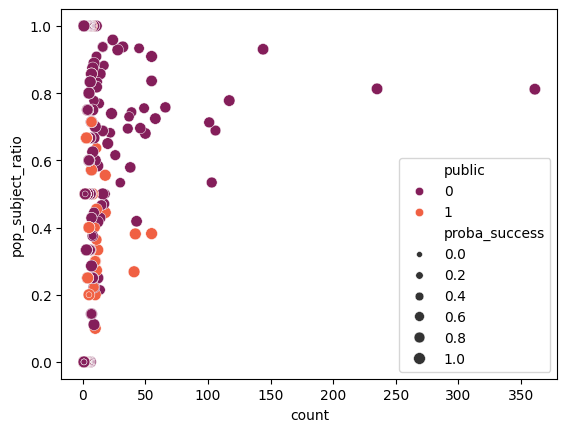

In [40]:
sns.scatterplot(data=sponsor_data, x="count", y="pop_subject_ratio", hue="public", size="proba_success", palette = 'rocket', size_norm = (0,1))

In [41]:
#afin de donner plus d'amplitude aux données on applique une fonction exponentielle, mais cela n'est pas probant
sponsor_data['exp_proba_success']=sponsor_data.proba_success.apply(lambda x: np.exp(x))

In [42]:
sponsor_data

,count,public,proba_success,pop_subject_ratio,exp_proba_success
Sponsor,,,,,
GlaxoSmithKline,361,0,0.933518,0.811634,2.543441
Merck Sharp & Dohme LLC,235,0,0.931915,0.812766,2.539367
Novo Nordisk A/S,144,0,0.909722,0.930556,2.483633
Organon and Co,117,0,0.931624,0.777778,2.538628
Novartis Pharmaceuticals,106,0,0.773585,0.688679,2.167523
...,...,...,...,...,...
Abivax S.A.,1,0,0.000000,0.000000,1.000000
Gedeon Richter Plc.,1,0,1.000000,1.000000,2.718282
Moleac Pte Ltd.,1,0,1.000000,1.000000,2.718282


<Axes: xlabel='proba_success', ylabel='pop_subject_ratio'>

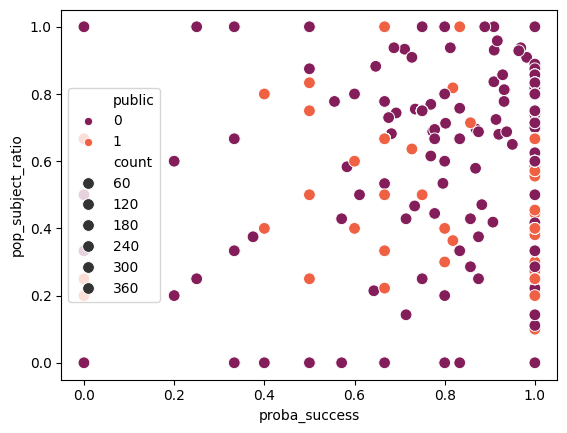

In [43]:
sns.scatterplot(data=sponsor_data, x="proba_success", y="pop_subject_ratio", hue="public", size="count", palette = 'rocket', size_norm = (0,1))

<Axes: >

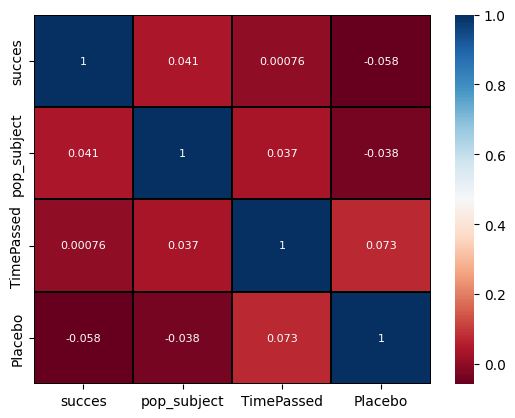

In [44]:
sns.heatmap(etude[['succes', 'pop_subject', 'TimePassed', 'Placebo']].corr(), cmap='RdBu', annot_kws={'size':8}, linecolor='black', annot = True, linewidths = 0.01)


Les corrélations sont très faibles entre nos variables quantitatives ce qui nous amène à penser qu'elles n'expliqueraient que peu le succès ou l'abandon d'un essai clinique en phase III

In [46]:
sponsor_data.groupby('public').describe()

count                                                 proba_success  \
         count      mean        std  min  25%  50%  75%    max         count   
public                                                                         
0       1299.0  3.641263  14.768966  1.0  1.0  1.0  2.0  361.0        1299.0   
1        575.0  2.313043   3.813065  1.0  1.0  1.0  2.0   55.0         575.0   

                  ... pop_subject_ratio      exp_proba_success            \
            mean  ...               75%  max             count      mean   
public            ...                                                      
0       0.782069  ...               1.0  1.0            1299.0  2.318651   
1       0.808425  ...               1.0  1.0             575.0  2.361534   

                                                               
             std  min       25%       50%       75%       max  
public                                                         
0       0.661539  1.0  1.947734  2.718282  2.718282  2.718282  
1       0.624584  1.0  2.117000  2.718282  2.718282  2.718282  

[2 rows x 32 columns]

Peu de différence entre les établissements publics et privés en termes de performance : pas une variable binaire à garder pour la modélisation

## 5. Collaborators

In [47]:
print("Les essais cliniques ne présentant aucune données sur les collaborateurs impliqués représentent " + "\033[1m" "{:.1%}".format(etude.Collaborators.isna().sum()/etude.shape[0]) + "\033[0m" + " des essais qui ont passé la phase III")
print("Il n'est donc pas intéressant d'étudier ce facteur")

Les essais cliniques ne présentant aucune données sur les collaborateurs impliqués représentent 79.4% des essais qui ont passé la phase III
Il n'est donc pas intéressant d'étudier ce facteur


## 6. Funder Type

In [48]:
etude['Funder Type'].isna().sum()/etude.shape[0]

0.0

In [49]:
etude.groupby('Funder Type').Sponsor.nunique()

Funder Type
FED            7
INDIV          3
INDUSTRY     896
NETWORK       16
NIH            7
OTHER        878
OTHER_GOV     66
UNKNOWN        1
Name: Sponsor, dtype: int64

In [50]:
pd.DataFrame(data = {'proba_success':etude.groupby('Funder Type').succes.sum()/etude.groupby('Funder Type').Bin.sum(), 'nb_sponsors' : etude.groupby('Funder Type').Sponsor.nunique(), 'pop_subject_ratio':etude.groupby('Funder Type').pop_subject.sum()/etude.groupby('Funder Type').Bin.sum()})
#NIH = national institutes of health

,proba_success,nb_sponsors,pop_subject_ratio
Funder Type,,,
FED,0.444444,7,0.555556
INDIV,1.000000,3,0.333333
INDUSTRY,0.846766,896,0.674469
NETWORK,0.652174,16,0.695652
NIH,0.904762,7,0.428571
OTHER,0.803213,878,0.514056
OTHER_GOV,0.913793,66,0.431034
UNKNOWN,1.000000,1,1.000000


In [51]:
etude.Locations

0                                                     NaN
1       Alliance for Multispecialty Research, LLC., Mo...
2                                                     NaN
3       Beach Clinical Research, Inc., Huntington Beac...
4       Ps0032 20211, Bucheon-si, Korea, Republic of|P...
                              ...                        
6055    Kantonsspital Aarau AG, Aarau, 5001, Switzerla...
6056                                                  NaN
6057    Universiti Kebangsaan Malaysia Medical Centre,...
6058    Skin Care Centre, Los Angeles, California, 900...
6059    Arizona Arrhythmia Research Center, Phoenix, A...
Name: Locations, Length: 6060, dtype: object

## Sponsor reputation

En scrappant les données de clinicaltrials.gov, on peut compter le nombre d'essais cliniques recensés par le site, par sponsor. On suppose que le nombre d'essais est croissant avec le taux de succès 

In [52]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import urllib
base_url = "https://clinicaltrials.gov/search?spons="

def number_of_studies_sponsor(sponsor):
    url = base_url + urllib.parse.quote(str(sponsor))
    driver = webdriver.Chrome()
    driver.get(url)

    driver.implicitly_wait(10)

    css_selector = "#searchResultsIntro > div > p"
    selected_element = driver.find_element(By.CSS_SELECTOR, css_selector)

    if selected_element:
        element_text = selected_element.text.strip()
        return element_text
    else:
        return "Element not found"
    
    driver.quit()

In [53]:
sponsor_data['nb_studies_sponsor'] = sponsor_data.index.map(number_of_studies_sponsor)

WebDriverException: Message: disconnected: unable to send message to renderer
  (failed to check if window was closed: disconnected: not connected to DevTools)
  (Session info: chrome=120.0.6099.130)
Stacktrace:
	GetHandleVerifier [0x00007FF677C52142+3514994]
	(No symbol) [0x00007FF677870CE2]
	(No symbol) [0x00007FF6777176AA]
	(No symbol) [0x00007FF6776FEB20]
	(No symbol) [0x00007FF6776FF7CE]
	(No symbol) [0x00007FF67771AF81]
	(No symbol) [0x00007FF67771BA98]
	(No symbol) [0x00007FF67771F38F]
	(No symbol) [0x00007FF67771F480]
	(No symbol) [0x00007FF677761624]
	(No symbol) [0x00007FF67776197C]
	(No symbol) [0x00007FF6777A4EE7]
	(No symbol) [0x00007FF67778602F]
	(No symbol) [0x00007FF6777A28F6]
	(No symbol) [0x00007FF677785D93]
	(No symbol) [0x00007FF677754BDC]
	(No symbol) [0x00007FF677755C64]
	GetHandleVerifier [0x00007FF677C7E16B+3695259]
	GetHandleVerifier [0x00007FF677CD6737+4057191]
	GetHandleVerifier [0x00007FF677CCE4E3+4023827]
	GetHandleVerifier [0x00007FF6779A04F9+689705]
	(No symbol) [0x00007FF67787C048]
	(No symbol) [0x00007FF677878044]
	(No symbol) [0x00007FF6778781C9]
	(No symbol) [0x00007FF6778688C4]
	BaseThreadInitThunk [0x00007FF93932257D+29]
	RtlUserThreadStart [0x00007FF93AA2AA58+40]


In [ ]:
sponsor_data['nb_studies_sponsor']

Sponsor
GlaxoSmithKline                                                                            Viewing 1-10 out of 4 727 studies
Merck Sharp & Dohme LLC                                                                    Viewing 1-10 out of 3 867 studies
Novo Nordisk A/S                                                                           Viewing 1-10 out of 1 478 studies
Organon and Co                                                                               Viewing 1-10 out of 492 studies
Novartis Pharmaceuticals                                                                   Viewing 1-10 out of 2 849 studies
                                                                                                         ...                
Eunice Kennedy Shriver National Institute of Child Health and Human Development (NICHD)    Viewing 1-10 out of 1 927 studies
Immunic AG                                                                                      Viewing 1-8 out of 8 

In [ ]:
test_string = "Viewing 1-8 out of 8 studies"
''.join(list(filter(lambda x: x.isdigit(), test_string.split())))

'8'

In [ ]:
sponsor_data.to_csv(r"C:\Users\zargo\OneDrive\Documents\ENSAE 2AD\projet python\ProjetPython\Succès Essai Clinique\sponsor_data.csv")

In [ ]:
# Define a regular expression to match the desired pattern and extract the second numeric part

# Use str.extract to extract the desired part of the pattern
sponsor_data['nb_studies_sponsor_digit'] = sponsor_data['nb_studies_sponsor'].map(lambda x: ''.join(list(filter(lambda c : c.isdigit(), x.split()))))

# Display the DataFrame with the extracted values
print(sponsor_data)


                                                    count  public  \
Sponsor                                                             
GlaxoSmithKline                                       361       0   
Merck Sharp & Dohme LLC                               235       0   
Novo Nordisk A/S                                      144       0   
Organon and Co                                        117       0   
Novartis Pharmaceuticals                              106       0   
...                                                   ...     ...   
Eunice Kennedy Shriver National Institute of Ch...      1       1   
Immunic AG                                              1       0   
Clasado Biosciences Ltd                                 1       0   
Servier                                                 1       0   
SatRx LLC                                               1       0   

                                                    proba_success  \
Sponsor                          

In [54]:
etude['nb_locations']=etude.Locations.map(lambda x: str(x).count('|')+1)

In [ ]:
etude = pd.merge(etude, sponsor_data[['public', 'nb_studies_sponsor_digit']], left_on='Sponsor', right_index=True, how='left')

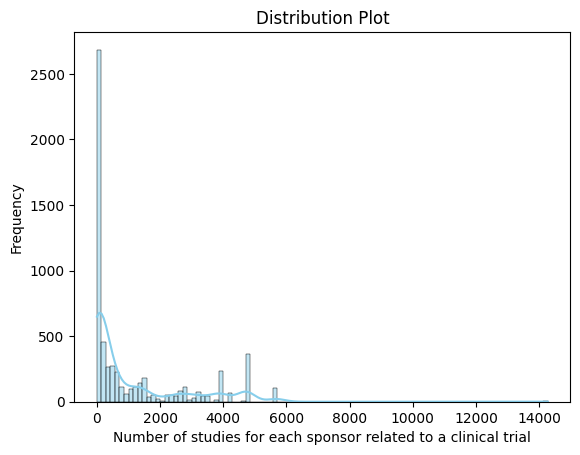

In [ ]:
# Create a histogram using Seaborn
sns.histplot(data=etude, x='nb_studies_sponsor_digit', bins=100, kde=True, color='skyblue')

# Add labels and title
plt.xlabel('Number of studies for each sponsor related to a clinical trial')
plt.ylabel('Frequency')
plt.title('Distribution Plot')

# Show the plot
plt.show()

In [59]:
data_augmented_final = pd.read_csv('Data_augmented_final.csv')
data_augmented_final.rename(columns={"Conditions": "Eligibility_Criteria"}, inplace=True)
data_augmented_final['Eligibility_Criteria']=data_augmented_final['Eligibility_Criteria'].fillna(0)
data_augmented_final['Eligibility_Criteria']=data_augmented_final['Eligibility_Criteria'].astype('int')

C:\Users\zargo\AppData\Local\Temp\ipykernel_20688\3766460218.py:1: DtypeWarning: Columns (6,7,8,9,14,15,16,17,18,19,21,22,23,24,25,26,27,28,29,33,34,35,36,37,38,39,40,41,46,47,55,83,84,85,86,91,92,93,94,95,97,98,99,101,105,106,107,108,109,113,114,115,116,117,118,119,120,122,125,126,167,173,178,187,193,194,195,196,197,198,199,203,207,209,211,212,213,215,216,217,218,219,220,221,222,223,224,225,226,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,265,266,267,268,269,282,283,285,286,287,288,289,290,292,303,304,305,306,307,311,323,324,325,327,328,329,331) have mixed types. Specify dtype option on import or set low_memory=False.
  data_augmented_final = pd.read_csv('Data_augmented_final.csv')


In [63]:
etude = pd.merge(etude, data_augmented_final[['NCTId', 'Eligibility_Criteria']], left_on = 'NCT Number', right_on = 'NCTId', how='left')

<Axes: >

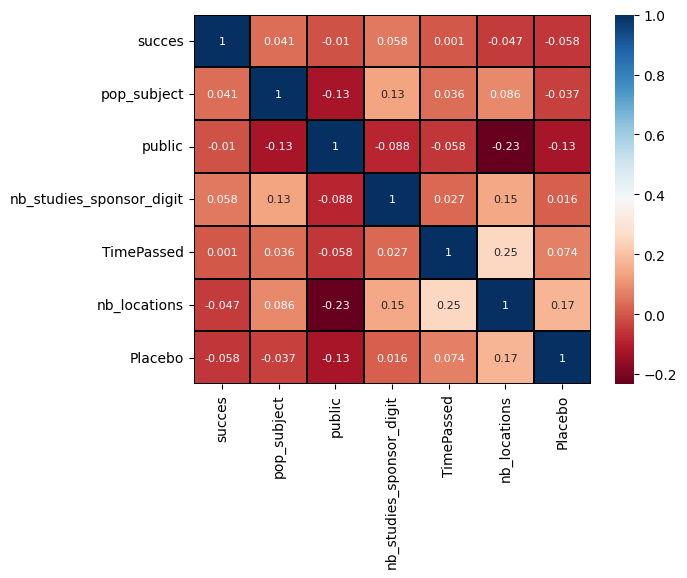

In [ ]:
sns.heatmap(etude[['succes', 'pop_subject', 'public', 'Eligibility_Criteria','nb_studies_sponsor_digit','TimePassed', 'nb_locations', 'Placebo']].corr(), cmap='RdBu', annot_kws={'size':8}, linecolor='black', annot = True, linewidths = 0.01)


### Logistic regression results

Sans appliquer de poids à la fonction de perte car les classes sont mal équilibrés (ratio de presque 1:5)

In [ ]:
etude['nb_studies_sponsor_digit'] = etude['nb_studies_sponsor_digit'].astype('int')

In [ ]:
etude[['nb_studies_sponsor_digit','public', 'pop_subject', 'Eligibility_Criteria', 'TimePassed', 'nb_locations', 'Placebo']].dtypes

nb_studies_sponsor_digit      int32
public                        int32
pop_subject                   int32
TimePassed                  float64
nb_locations                  int64
Placebo                       int32
dtype: object

In [76]:
etude['Eligibility_Criteria']=etude['Eligibility_Criteria'].fillna(0)

In [ ]:
import statsmodels.api as sm
scaler = StandardScaler()
Xtrain = sm.add_constant(etude[['nb_studies_sponsor_digit','public', 'Eligibility_Criteria', 'pop_subject', 'TimePassed', 'nb_locations', 'Placebo']])
ytrain = etude[['succes']] 

log_reg = sm.Logit(ytrain, Xtrain).fit() 


Optimization terminated successfully.
         Current function value: 0.443568
         Iterations 6


In [78]:
print(log_reg.summary()) 


                           Logit Regression Results                           
Dep. Variable:                 succes   No. Observations:                 6060
Model:                          Logit   Df Residuals:                     6053
Method:                           MLE   Df Model:                            6
Date:                Fri, 29 Dec 2023   Pseudo R-squ.:                 0.01009
Time:                        22:54:45   Log-Likelihood:                -2691.7
converged:                       True   LL-Null:                       -2719.1
Covariance Type:            nonrobust   LLR p-value:                 4.864e-10
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.6891      0.097     17.369      0.000       1.498       1.880
public                  -0.1639      0.087     -1.890      0.059      -0.334       0.006
Eligibility_

En appliquant un poids en utilisant "class_weights":

In [87]:
def prepare_model(data, class_col, cols_to_include):

  cols = data.select_dtypes(include=np.number).columns.tolist() 
  X = data[cols]
  X = X[X.columns.difference([class_col])] 
  X = X[cols_to_include]
  y = data[class_col]
  return train_test_split(X, y, test_size=0.25, random_state=0) #  train test split
def run_model_bweights(X_train, X_test, y_train, y_test):
    logreg = LogisticRegression(random_state=13, class_weight='balanced') # parametre pour class_weight
    #Explication de la documentation de sklearn : The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y)).
    logreg.fit(X_train, y_train) 
    y_pred = logreg.predict(X_test)
    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test)) # ROC AUC score
    print(classification_report(y_test, y_pred)) 
    print("The area under the curve is:", logit_roc_auc) # AUC curve

In [ ]:
X_train, X_test, y_train, y_test = prepare_model(etude, class_col='succes', cols_to_include=['nb_studies_sponsor_digit', 'pop_subject', 'Eligibility_Criteria', 'TimePassed', 'nb_locations', 'Placebo'])
y_pred = run_model_bweights(X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.21      0.61      0.32       250
           1       0.88      0.55      0.68      1264

    accuracy                           0.56      1514
   macro avg       0.55      0.58      0.50      1514
weighted avg       0.77      0.56      0.62      1514

The area under the curve is: 0.582503164556962


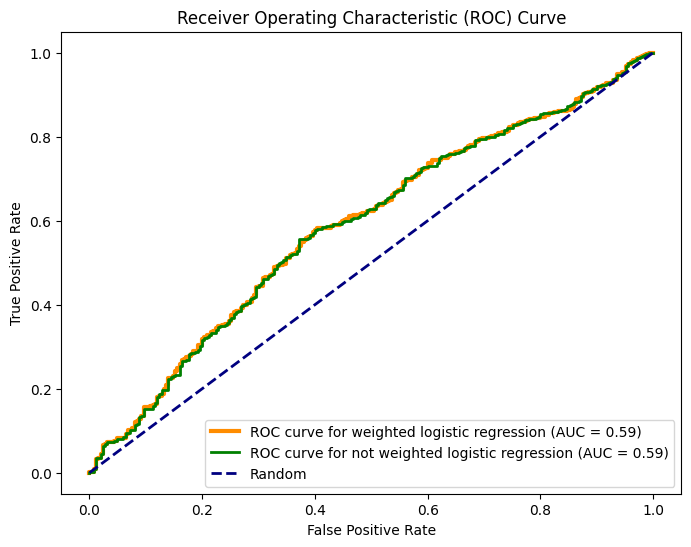

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(etude[['nb_studies_sponsor_digit', 'pop_subject', 'Eligibility_Criteria', 'TimePassed', 'nb_locations', 'Placebo']], etude['succes'], test_size=0.25, random_state=0)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression model and train it on the scaled data
model = LogisticRegression(random_state=13, class_weight='balanced')
model1=LogisticRegression(random_state=13)

model.fit(X_train_scaled, y_train)
model1.fit(X_train_scaled, y_train)
y_probabilities = model.predict_proba(X_test_scaled)[:, 1]
y1_probabilities = model1.predict_proba(X_test_scaled)[:, 1]

from sklearn.metrics import roc_curve, auc
# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
fpr1, tpr1, thresholds1 = roc_curve(y_test, y1_probabilities)

# Calculate the area under the ROC curve (AUC)
roc_auc = auc(fpr, tpr)
roc_auc1 = auc(fpr1, tpr1)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=3, label=f'ROC curve for weighted logistic regression (AUC = {roc_auc:.2f})')
plt.plot(fpr1, tpr1, color='green', lw=2, label=f'ROC curve for not weighted logistic regression (AUC = {roc_auc1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

On n'a pas beaucoup amélioré notre modèle en prenant en compte le fait que les classes étaient déséquilibrées.